In [74]:
import sys
from pathlib import Path
import random

import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import gaussian_kde

# Import the utilities from the project
from dataloader import (
    get_tasks_dict,
    random_split_tasks,
    get_pairs_from_tasks,
    visualize_image_pair_count_distribution
)

from dataloader import SegmentationDataset

print("All imports successful!")


All imports successful!


In [75]:
# Point to your dataset location as configured in your project.
# Make sure to match the path in your configurator.py or train.py
dataset_path = Path("../dataset/12-15-2024_madreporiteSegmentor")

# Get a dictionary of tasks, each with a list of (image_path, mask_path) pairs
tasks_dict = get_tasks_dict(dataset_path)

print(f"Found {len(tasks_dict)} tasks in the dataset.")
# Let's list them (task names) and the number of image-mask pairs in each:
for task_name, pairs in tasks_dict.items():
    print(f"Task '{task_name}': {len(pairs)} image-mask pairs.")


Found 100 tasks in the dataset.
Task 'task_1085229_SORTED_STARS_CROPPED_clusters__cluster_0': 50 image-mask pairs.
Task 'task_1085230_SORTED_STARS_CROPPED_clusters__cluster_1': 50 image-mask pairs.
Task 'task_1085231_SORTED_STARS_CROPPED_clusters__cluster_10': 50 image-mask pairs.
Task 'task_1085233_SORTED_STARS_CROPPED_clusters__cluster_11': 50 image-mask pairs.
Task 'task_1085234_SORTED_STARS_CROPPED_clusters__cluster_12': 50 image-mask pairs.
Task 'task_1085243_SORTED_STARS_CROPPED_clusters__cluster_13': 50 image-mask pairs.
Task 'task_1085253_SORTED_STARS_CROPPED_clusters__cluster_14': 50 image-mask pairs.
Task 'task_1085261_SORTED_STARS_CROPPED_clusters__cluster_15': 50 image-mask pairs.
Task 'task_1085267_SORTED_STARS_CROPPED_clusters__cluster_16': 49 image-mask pairs.
Task 'task_1085272_SORTED_STARS_CROPPED_clusters__cluster_17': 50 image-mask pairs.
Task 'task_1085282_SORTED_STARS_CROPPED_clusters__cluster_18': 50 image-mask pairs.
Task 'task_1085289_SORTED_STARS_CROPPED_cluste

Randomly selected task to display: task_1085507_armPits_clusters__cluster_0


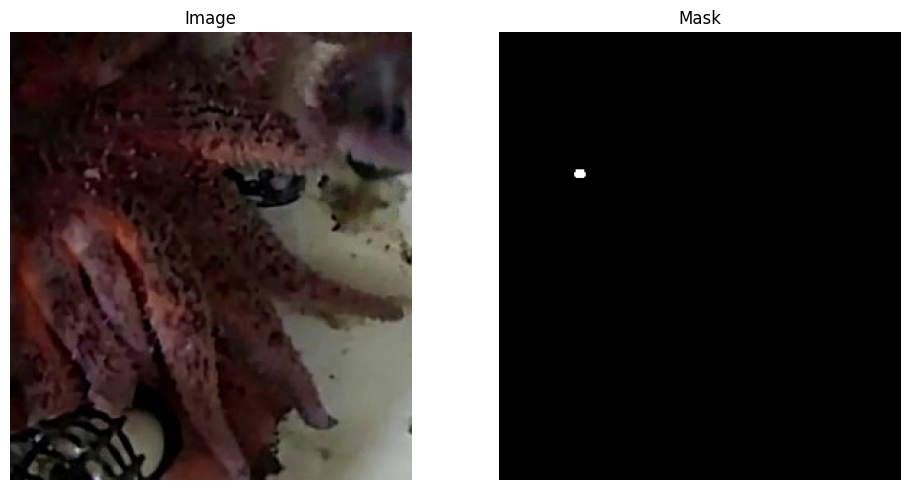

Randomly selected task to display: task_1085554_armPits_clusters__cluster_8


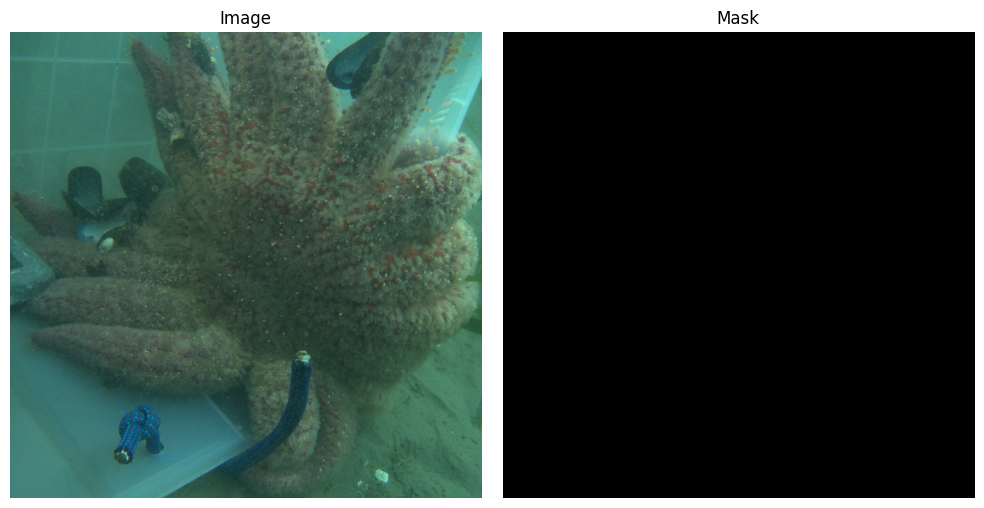

Randomly selected task to display: task_1085515_armPits_clusters__cluster_11


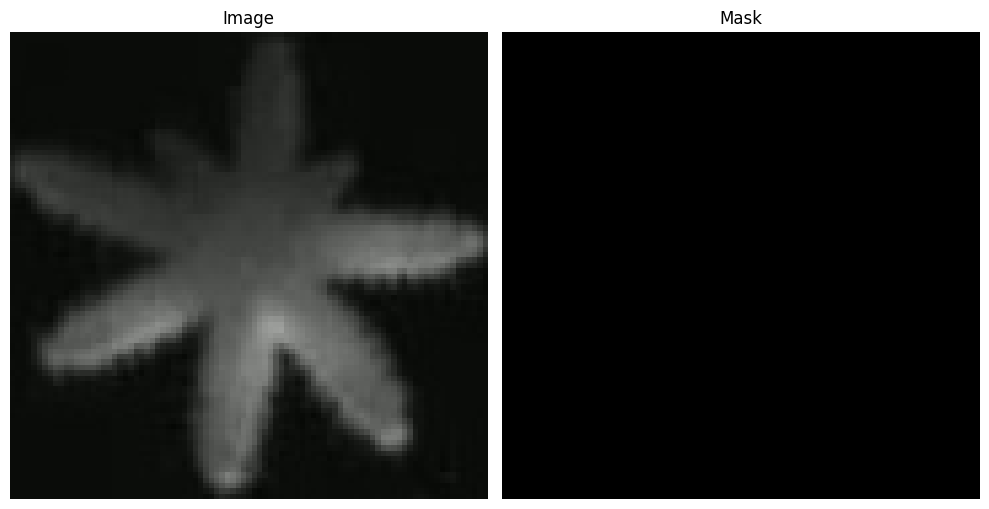

Randomly selected task to display: task_1085282_SORTED_STARS_CROPPED_clusters__cluster_18


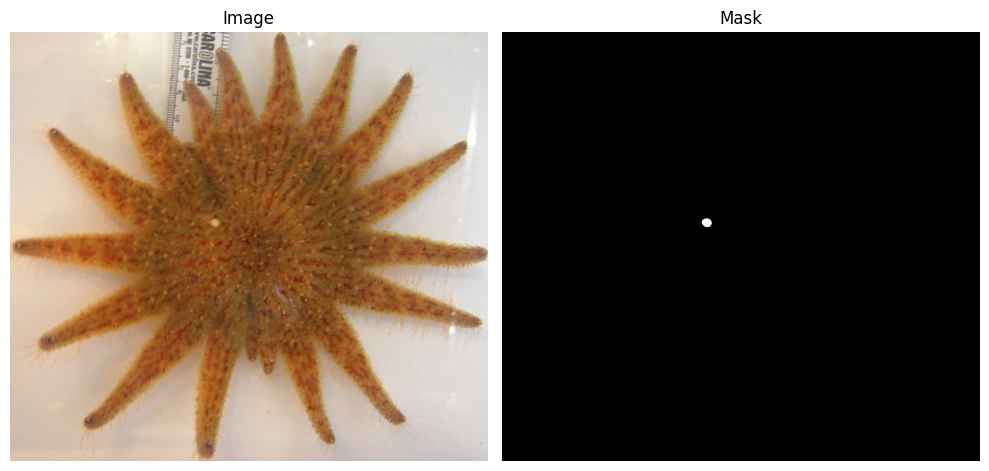

Randomly selected task to display: task_1085540_armPits_clusters__cluster_3


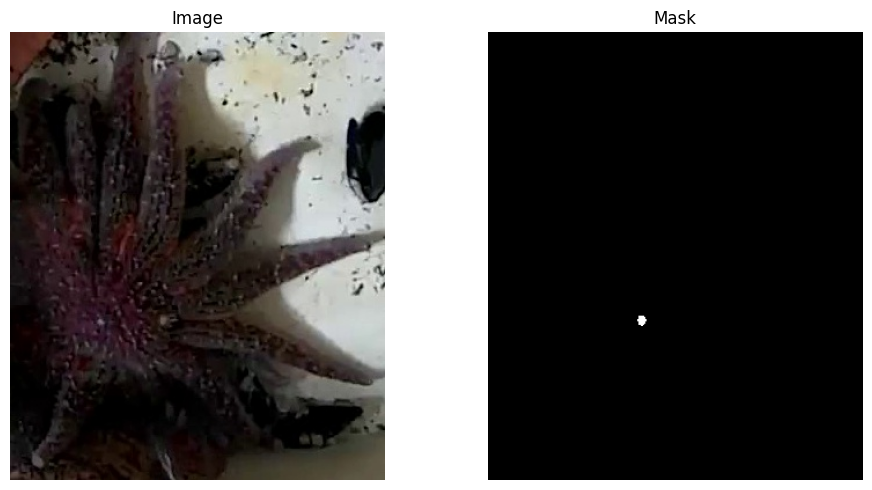

Randomly selected task to display: task_1085870_cropped_sequence_sorted_r2_clusters__cluster_16


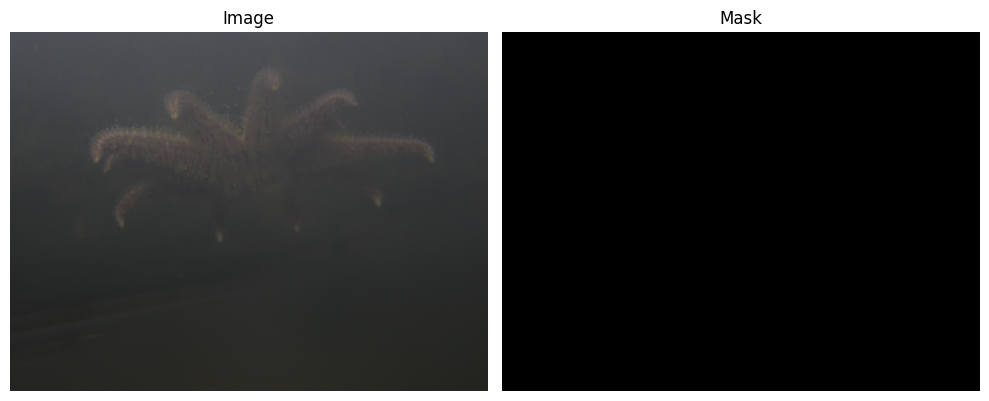

Randomly selected task to display: task_1085707_splitSSWDfieldPics_clusters__cluster_6


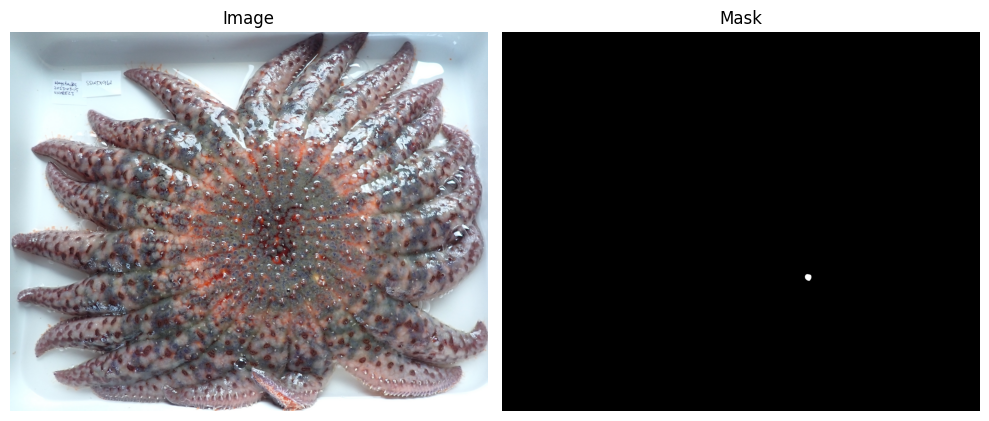

Randomly selected task to display: task_1085302_SORTED_STARS_CROPPED_clusters__cluster_4


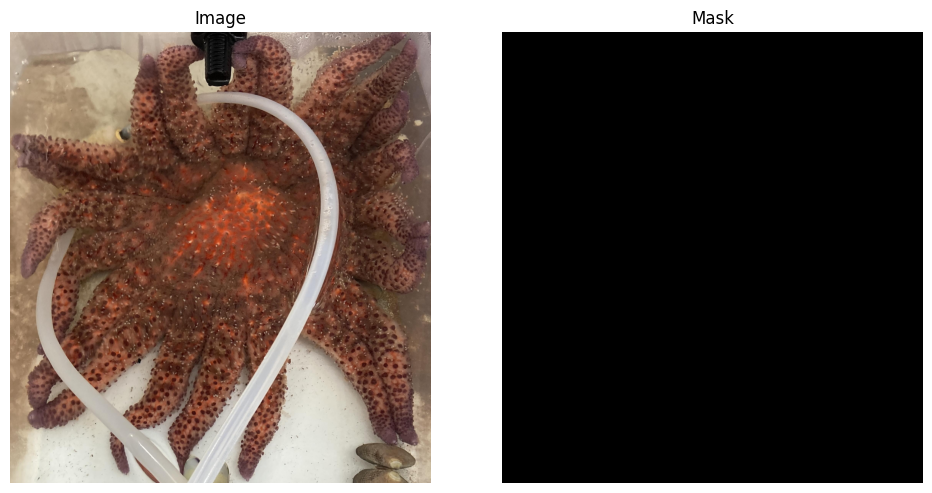

Randomly selected task to display: task_1085557_armPits_clusters__cluster_9


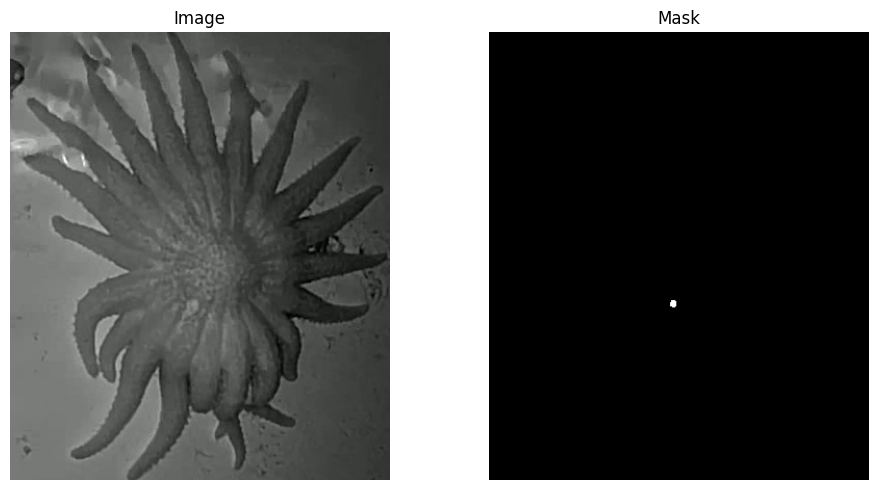

Randomly selected task to display: task_1085830_cropped_sequence_sorted_r2_clusters__cluster_1


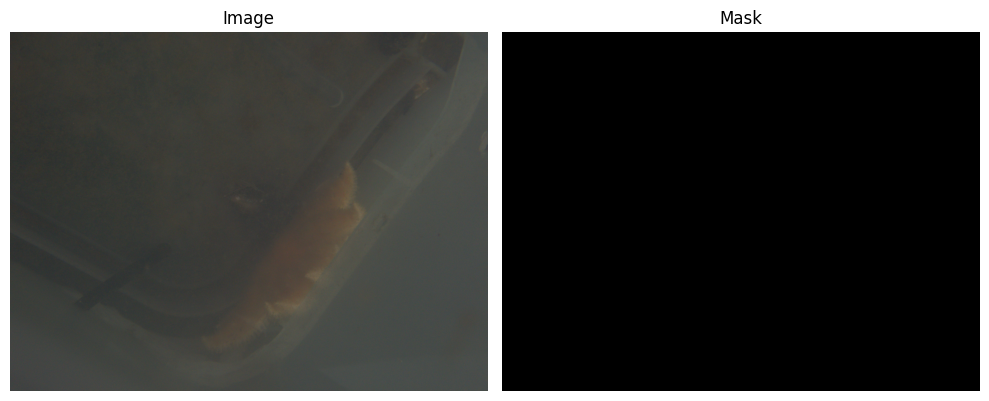

In [76]:

def show_image_and_mask(image_path: Path, mask_path: Path):
    """
    Load an image and its mask from disk and display side-by-side.
    """
    image = np.array(Image.open(image_path).convert("RGB"))
    mask = np.array(Image.open(mask_path).convert("L"))

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(image)
    axs[0].set_title("Image")
    axs[0].axis("off")

    axs[1].imshow(mask, cmap="gray")
    axs[1].set_title("Mask")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()

for i in range(0,10):
    # Pick a random task and a random pair inside it
    random_task_name = random.choice(list(tasks_dict.keys()))
    pairs_in_task = tasks_dict[random_task_name]
    random_pair = random.choice(pairs_in_task)

    print(f"Randomly selected task to display: {random_task_name}")
    show_image_and_mask(*random_pair)


In [77]:

ratios_h = []
ratios_w = []
num_with_masks = 0
num_without_masks = 0
total_images = 0

pbar = tqdm(total=len(tasks_dict), desc="Processing masks")
for task_name, pairs in tasks_dict.items():
    for (img_path, mask_path) in pairs:
        # Load mask as grayscale
        mask = np.array(Image.open(mask_path).convert("L"))
        total_images += 1

        # Check if mask has any nonzero pixels
        if mask.sum() == 0:
            num_without_masks += 1
            continue  # no object in this mask, skip
        num_with_masks += 1

        # Convert to binary
        mask_binary = (mask > 0).astype(np.uint8)

        # Run connectedComponentsWithStats
        num_labels, labels_im, stats, centroids = cv2.connectedComponentsWithStats(mask_binary, connectivity=8)

        # Find the largest connected component by area (excluding label 0=background)
        largest_area = 0
        largest_label = -1
        for label in range(1, num_labels):
            area = stats[label, cv2.CC_STAT_AREA]
            if area > largest_area:
                largest_area = area
                largest_label = label

        # Extract bounding box height/width of the largest CC
        # stats columns: [CV_STAT_LEFT, CV_STAT_TOP, CV_STAT_WIDTH, CV_STAT_HEIGHT, CV_STAT_AREA]
        largest_bbox_w = stats[largest_label, cv2.CC_STAT_WIDTH]
        largest_bbox_h = stats[largest_label, cv2.CC_STAT_HEIGHT]

        # Compute ratios to the full mask size (same as image size if mask matches image)
        full_h, full_w = mask.shape
        ratio_h = largest_bbox_h / full_h
        ratio_w = largest_bbox_w / full_w

        ratios_h.append(ratio_h)
        ratios_w.append(ratio_w)

    pbar.update(1)
pbar.close()

print(f"Found {len(ratios_h)} objects among all masks in the dataset with nonzero foreground.")
print(f"Found {num_with_masks} masks with nonzero foreground and {num_without_masks} masks with no foreground.")
print(f"Processed {total_images} images in total.")
print()

rate_with_masks = num_with_masks / total_images
print(f"Rate of images with masks: {rate_with_masks:.4f}")
rate_without_masks = num_without_masks / total_images
print(f"Rate of images without masks: {rate_without_masks:.4f}")
print()

# Quick summary statistics
min_ratio_h = np.min(ratios_h)
max_ratio_h = np.max(ratios_h)
mean_ratio_h = np.mean(ratios_h)
std_ratio_h = np.std(ratios_h)
print("Height ratio: min = {:.4f}, max = {:.4f}, mean = {:.4f}, std = {:.4f}".format(
    min_ratio_h, max_ratio_h, mean_ratio_h, std_ratio_h
))

min_ratio_w = np.min(ratios_w)
max_ratio_w = np.max(ratios_w)
mean_ratio_w = np.mean(ratios_w)
std_ratio_w = np.std(ratios_w)
print("Width ratio:  min = {:.4f}, max = {:.4f}, mean = {:.4f}, std = {:.4f}".format(
    min_ratio_w, max_ratio_w, mean_ratio_w, std_ratio_w
))

Processing masks: 100%|██████████| 100/100 [00:44<00:00,  2.24it/s]

Found 1212 objects among all masks in the dataset with nonzero foreground.
Found 1212 masks with nonzero foreground and 473 masks with no foreground.
Processed 1685 images in total.

Rate of images with masks: 0.7193
Rate of images without masks: 0.2807

Height ratio: min = 0.0024, max = 0.1200, mean = 0.0234, std = 0.0094
Width ratio:  min = 0.0035, max = 0.1062, mean = 0.0220, std = 0.0086


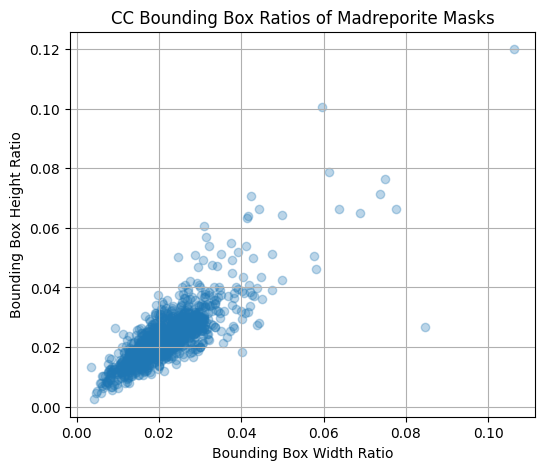

In [78]:
fig, ax = plt.subplots(1,1, figsize=(6, 5))
ax.scatter(ratios_w, ratios_h, alpha=0.3)
ax.set_xlabel("Bounding Box Width Ratio")
ax.set_ylabel("Bounding Box Height Ratio")
ax.set_title("CC Bounding Box Ratios of Madreporite Masks")
ax.grid(True)
plt.show()

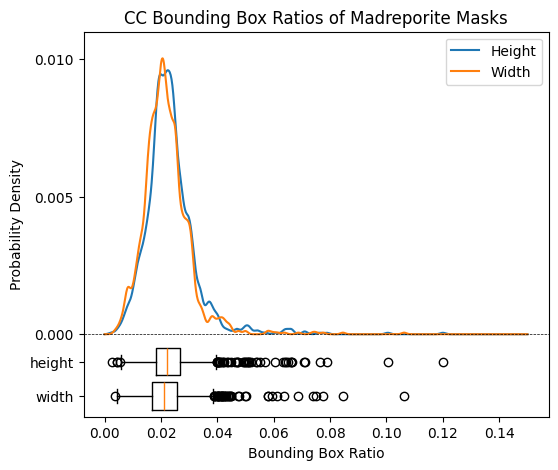

In [79]:
## plot kde curves of the ratios on the same plot
fig, ax = plt.subplots(1,1, figsize=(6, 5))

# compute the kernel density estimate
kde_h = gaussian_kde(ratios_h, bw_method=0.1)
kde_w = gaussian_kde(ratios_w, bw_method=0.1)

# plot the kde curves
x = np.linspace(0, .15, 1000)
y = kde_h(x)
y /= y.sum()

ax.plot(x, y, label="Height")

x = np.linspace(0, .15, 1000)
y = kde_w(x)
y /= y.sum()

ax.plot(x, y, label="Width")

ax.boxplot([ratios_h, ratios_w], vert=False, positions=[-0.001, -0.00225], widths=0.001)

yticks = ax.get_yticks()
yticks = np.append(yticks, [0, 0.005, 0.01])
yticklabels = ['height', 'width'] + [f"{y:.3f}" for y in yticks[2:]]
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)

ax.axhline(0, color='black', lw=0.5, ls='--')

ax.set_xlabel("Bounding Box Ratio")
ax.set_ylabel("Probability Density")

ax.set_title("CC Bounding Box Ratios of Madreporite Masks")

ax.set_ylim(-0.003, 0.011)

ax.legend()

plt.show()


In [80]:
magic_ratio = np.mean([mean_ratio_h, mean_ratio_w])
print(f"Magic ratio: {magic_ratio:.4f}")

Magic ratio: 0.0227


In [81]:
refinement_ratio = magic_ratio*10
print(f"Refinement ratio: {refinement_ratio:.4f}")

Refinement ratio: 0.2268
